#1. INITIALIZATION

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import math
import datetime as dt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

Importing essential libraries for data manipulation, visualization, machine learning models, and time series analysis. Setting seeds ensures reproducible results

##Data Fetching

In [6]:
# Define ticker and date range
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')

# Fetch stock data
data = yf.download(ticker, start=start_date, end=end_date)

# Check for NaN values and handle them
if data.isnull().values.any():
    print("NaN values found in data. Filling with forward fill method.")
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)

print(f"Downloaded {len(data)} rows of data")
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Downloaded 2591 rows of data


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.320433,24.789802,23.879981,24.778679,212818400
2015-01-05,23.635288,24.169168,23.448431,24.089086,257142000
2015-01-06,23.637508,23.897774,23.274914,23.699794,263188400
2015-01-07,23.968962,24.069063,23.735389,23.846614,160423600
2015-01-08,24.889904,24.947741,24.180289,24.298189,237458000


Downloading historical stock data using yfinance API. We perform basic data cleaning by filling any missing values using forward and backward fill methods.

##Linear Regression Model - Data Preprocessing

In [7]:
def preprocess_for_linear_regression(data):
    """Preprocess data for linear regression model"""
    # Create a copy to avoid modifying original data
    df = data.copy()

    # Calculate moving averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()

    # Calculate price momentum indicators
    df['Price_Change'] = df['Close'].pct_change()
    df['Price_Change_5d'] = df['Close'].pct_change(periods=5)
    df['Price_Change_20d'] = df['Close'].pct_change(periods=20)

    # Volume indicators
    df['Volume_Change'] = df['Volume'].pct_change()
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()

    # Volatility indicators
    df['Volatility'] = df['Close'].rolling(window=20).std()

    # Remove NaN values that result from rolling calculations
    df = df.dropna()

    # Create features and target
    features = ['MA5', 'MA20', 'MA50', 'Price_Change', 'Price_Change_5d',
              'Price_Change_20d', 'Volume_Change', 'Volume_MA5', 'Volatility']

    X = df[features]
    y = df['Close']

    return X, y, df

# Preprocess data for linear regression
features_lr, target_lr, processed_df = preprocess_for_linear_regression(data)

# Display the first few rows of features
print("Linear Regression Features:")
features_lr.head()

Linear Regression Features:


Price,MA5,MA20,MA50,Price_Change,Price_Change_5d,Price_Change_20d,Volume_Change,Volume_MA5,Volatility
Ticker,,,,,,,,,
Date,,,,,,,,,
2015-03-16,27.681018,28.521401,26.677913,0.011004,-0.017225,-0.016761,-0.307811,219087920.0,0.618391
2015-03-17,27.794021,28.512579,26.758935,0.016727,0.020319,-0.006180,0.422274,204821120.0,0.619250
2015-03-18,28.072288,28.509788,26.860048,0.011256,0.050965,-0.001942,0.279242,201886640.0,0.618264
2015-03-19,28.208518,28.499180,26.956783,-0.007551,0.024508,-0.007396,-0.298164,199844080.0,0.616892
2015-03-20,28.311695,28.458980,27.039743,-0.012549,0.018691,-0.027799,0.499582,213338320.0,0.614151


Creating technical indicators that will serve as features for the linear regression model. These include moving averages, price momentum, volume indicators, and volatility measures which are common in financial analysis.

##Linear Regression Model - Train and Evaluate

In [8]:
# Split the data into training and testing sets (keeping time order)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    features_lr, target_lr, test_size=0.2, shuffle=False
)

# Train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

# Make predictions
lr_train_pred = lr_model.predict(X_train_lr)
lr_test_pred = lr_model.predict(X_test_lr)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # MAPE calculation with handling for zero values
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(1e-10, np.abs(y_true)))) * 100

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

lr_metrics = calculate_metrics(y_test_lr, lr_test_pred)
print("Linear Regression Model Metrics:")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.4f}")

Linear Regression Model Metrics:
MSE: 7.0491
RMSE: 2.6550
MAE: 1.8070
R2: 0.9893
MAPE: 0.9011


Training a linear regression model using our engineered features. We maintain the chronological order of data with shuffle=False which is essential for time series data. The model's performance is evaluated using multiple metrics including RMSE and R² score.

## Visualize Linear Regression Results

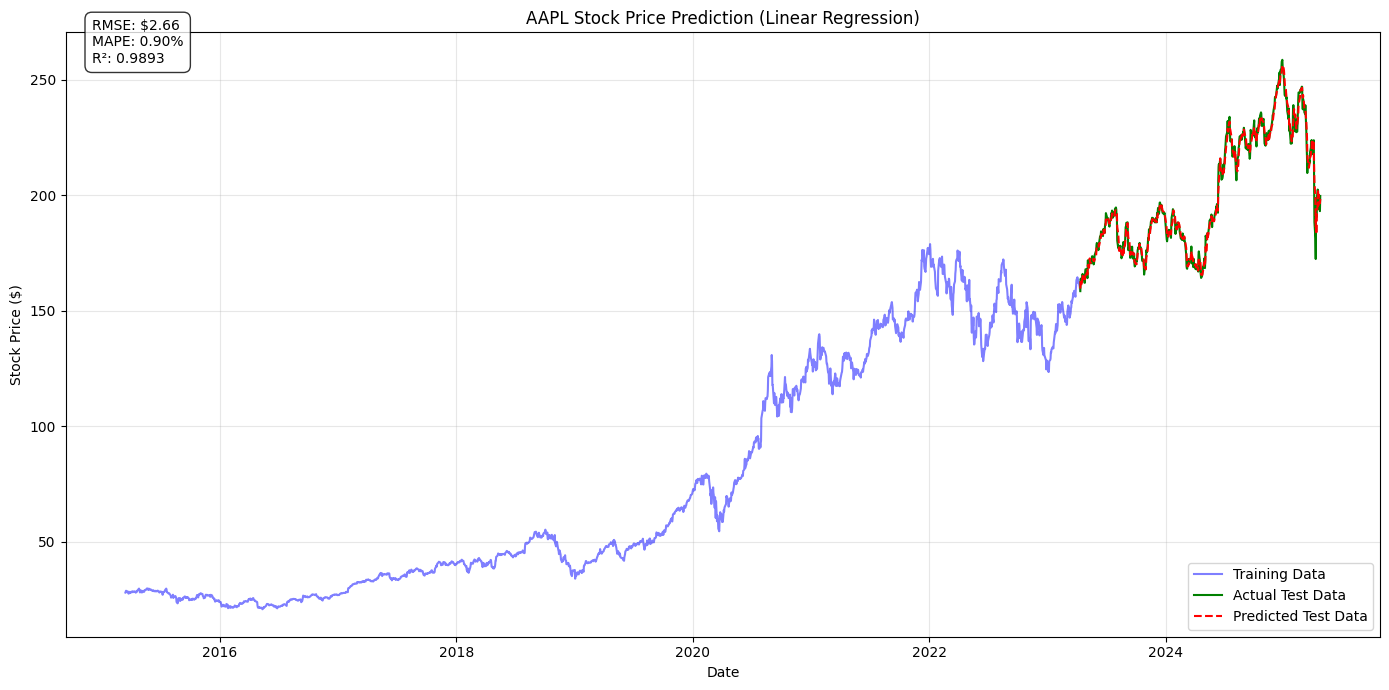

<Figure size 1000x600 with 0 Axes>

RMSE: $2.66
MAPE: 0.90%
R²: 0.9893


In [9]:
# Plot the linear regression results
plt.figure(figsize=(14, 7))

# Plot training data
train_dates = X_train_lr.index
test_dates = X_test_lr.index

# Plot actual prices
plt.plot(train_dates, y_train_lr, label='Training Data', color='blue', alpha=0.5)
plt.plot(test_dates, y_test_lr, label='Actual Test Data', color='green')

# Plot predicted prices
plt.plot(test_dates, lr_test_pred, label='Predicted Test Data', color='red', linestyle='--')

plt.title(f'{ticker} Stock Price Prediction (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add metrics as text
metrics_text = (f"RMSE: ${lr_metrics['RMSE']:.2f}\n"
                f"MAPE: {lr_metrics['MAPE']:.2f}%\n"
                f"R²: {lr_metrics['R2']:.4f}")
plt.annotate(metrics_text, xy=(0.02, 0.95), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Feature importance
plt.figure(figsize=(10, 6))
importance = np.abs(lr_model.coef_)

# Ensure importance is 1D
if importance.ndim > 1:
    importance = importance.flatten()

feat_importance = pd.DataFrame({
    'Feature': features_lr.columns,
    'Importance': importance
}).sort_values('Importance', ascending=False)

plt.tight_layout()
plt.show()
print(f"RMSE: ${lr_metrics['RMSE']:.2f}")
print(f"MAPE: {lr_metrics['MAPE']:.2f}%")
print(f"R²: {lr_metrics['R2']:.4f}")

Visualizing the linear regression model's predictions against actual prices. We also plot feature importance to understand which technical indicators have the most influence on the model's predictions.

##LSTM Model - Data Preprocessing




In [10]:
def preprocess_for_lstm(data, feature_columns=['Open', 'High', 'Low', 'Close', 'Volume']):
    """Preprocess data for LSTM model"""
    # Create features dataframe
    features = data[feature_columns].copy()

    # Add technical indicators
    # Moving Averages
    features['MA5'] = data['Close'].rolling(window=5).mean()
    features['MA20'] = data['Close'].rolling(window=20).mean()

    # RSI
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss.replace(0, np.finfo(float).eps)
    features['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = data['Close'].ewm(span=12).mean()
    ema26 = data['Close'].ewm(span=26).mean()
    features['MACD'] = ema12 - ema26
    features['MACD_signal'] = features['MACD'].ewm(span=9).mean()

    # Target is the closing price
    target = data['Close'].copy()

    # Drop rows with NaN values
    features.dropna(inplace=True)
    target = target.loc[features.index]

    return features, target

# Scale the data
def scale_data(features, target):
    # Scale features
    scaler_features = MinMaxScaler()
    scaled_features = scaler_features.fit_transform(features.values)
    scaled_features_df = pd.DataFrame(scaled_features, index=features.index,
                                     columns=features.columns)

    # Scale target
    scaler_target = MinMaxScaler()
    target_values = target.values.reshape(-1, 1)
    scaled_target = scaler_target.fit_transform(target_values).flatten()

    return scaled_features_df, scaled_target, scaler_features, scaler_target

# Create sequences for LSTM
def create_sequences(features, target, seq_length=60):
    X, y = [], []

    for i in range(len(features) - seq_length):
        X.append(features.iloc[i:i+seq_length].values)
        y.append(target[i+seq_length])

    return np.array(X), np.array(y)

# Preprocess data for LSTM
features_lstm, target_lstm = preprocess_for_lstm(data)
scaled_features, scaled_target, scaler_feat, scaler_targ = scale_data(features_lstm, target_lstm)

# Create sequences
seq_length = 60  # 60 days of historical data
X_seq, y_seq = create_sequences(scaled_features, scaled_target, seq_length)

print(f"LSTM data shape: X_seq: {X_seq.shape}, y_seq: {y_seq.shape}")

LSTM data shape: X_seq: (2512, 60, 10), y_seq: (2512,)


**Preparing data specifically for the LSTM model involves scaling (normalization) and sequence creation. Each input is a sequence of 60 days of historical data including price, volume, and technical indicators.**

##**LSTM Model - Build and Train**

In [11]:
# Split the sequence data
train_size = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
y_train_seq, y_test_seq = y_seq[:train_size], y_seq[train_size:]

# Build a simple LSTM model
def build_lstm_model(input_shape):
    model = tf.keras.Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the LSTM model
lstm_model = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]))

# Setup early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
lstm_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions
lstm_test_pred = lstm_model.predict(X_test_seq)

# Inverse transform predictions and actual values
lstm_test_pred_rescaled = scaler_targ.inverse_transform(lstm_test_pred).flatten()
y_test_seq_rescaled = scaler_targ.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

# Calculate metrics
lstm_metrics = calculate_metrics(y_test_seq_rescaled, lstm_test_pred_rescaled)
print("\nLSTM Model Metrics:")
for metric, value in lstm_metrics.items():
    print(f"{metric}: {value:.4f}")

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0154 - val_loss: 0.0012
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5144e-04 - val_loss: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8345e-04 - val_loss: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9593e-04 - val_loss: 9.6848e-04
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8357e-04 - val_loss: 8.9599e-04
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.6621e-04 - val_loss: 8.2603e-04
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6000e-04 - val_loss: 7.7785e-04
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5245e-04 - val_loss: 7.4897e-04
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4800e-04 - val_loss: 7.1843e-04
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4297e-04 - val_loss: 6.9806e-04
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3954e-04 - val_loss: 6.9090

**Building and training a stacked LSTM model for time series prediction. We use early stopping to prevent overfitting. The predictions are scaled back to the original price range for proper evaluation**